# Data Project from Physician Partners - Guided Solution

## Table of Contents

* [Assignment](#assignment)
* [Data exploration](#data-exploration)
* [Uni-variate outlier detection](#uni-variate-outlier-detection)
* [Multi-variate outlier detection](#multi-variate-outlier-detection)

## Assignment <a class="anchor" id="assignment"></a>

You need to create an algorithm that can find outliers in the data by one column / several columns. E.g., some members have extremely high costs for the current month and your solution should be able to detect such records. Think about features and how you would explain it to business people. All financial columns contain the `$` sign.

## Data exploration <a class="anchor" id="data-exploration"></a>

The task is pretty straightforward, but scarce in details. We only know that we should try to find outliers in the financial columns, based on just one column, or multiple. There is no restriction on the algorithm that is used, or the final outcome of the task. The only constraint is that we would present it to business people, and we need to be careful about how we will explain it.

Let's start first with the data exploration phase. We will use Pandas to read in the data provided in CSV format. Then, we will print the dataframe's columns, and a small sample of it. We should be able to visually identify the columns that contain a `$` sign - these are the column in which we will look for outliers.

In [1]:
import pandas as pd

In [2]:
sfrs = pd.read_csv("data/sfr_test.csv")

In [3]:
print(sfrs.columns)
rows, columns = sfrs.shape
print("We have", rows, "rows and", columns, "columns in the dataframe.")
sfrs.sample(n=5, random_state=42)

Index(['member_unique_id', 'gender', 'dob', 'eligible_year', 'eligible_month',
       'affiliation_type', 'pbp_group', 'plan_name', 'npi', 'line_of_business',
       'esrd', 'hospice', 'ipa_funding', 'ma_premium', 'ma_risk_score',
       'mbr_with_rx_rebates', 'partd_premium', 'pcp_cap', 'pcp_ffs',
       'plan_premium', 'prof', 'reinsurance', 'risk_score_partd', 'rx',
       'rx_rebates', 'rx_with_rebates', 'rx_without_rebates', 'spec_cap'],
      dtype='object')
We have 10530 rows and 28 columns in the dataframe.


,member_unique_id,gender,dob,eligible_year,eligible_month,affiliation_type,pbp_group,plan_name,npi,line_of_business,...,pcp_ffs,plan_premium,prof,reinsurance,risk_score_partd,rx,rx_rebates,rx_with_rebates,rx_without_rebates,spec_cap
4228,4229,M,08/06/1957,2020,202006,VIPcare,NON-SNP,MEDICARE - CAREFREE,32,HMO,...,$0.00,"$3,421.39",$0.00,$9.28,$0.00,$0.00,$0.00,$0.00,$0.00,$708.16
2128,2129,M,20/10/1950,2020,202006,Affiliate,D-SNP,NaN,19,HMO,...,$0.00,"$15,787.54",$0.00,$8.37,$0.00,"$2,148.68",$0.00,"$2,016.61","$2,005.57",$703.82
1408,1409,F,10/06/1947,2020,202006,Affiliate,NON-SNP,NaN,11,HMO,...,$0.00,"$8,371.59",$31.85,$8.50,$0.00,$646.66,$0.00,$687.77,$641.46,$682.94
5396,5397,F,26/03/1959,2020,202006,VIPcare,NON-SNP,NaN,41,HMO,...,$0.00,"$17,635.76",$0.00,$8.46,$0.00,$91.78,$0.00,$100.17,$88.83,$903.96
2870,2871,M,03/04/1942,2020,202006,Affiliate,NON-SNP,NaN,22,HMO,...,$0.00,"$17,128.22",$0.00,$9.45,$0.00,"$7,292.30",$0.00,"$6,996.36","$7,404.74",$851.34


Columns that contain the dollar `$` sign are: `ipa_funding`, `ma_premium`, `ma_risk_score`, `mbr_with_rx_rebates`, `partd_premium`, `pcp_cap`, `pcp_ffs`, `plan_premium`, `prof`, `reinsurance`, `risk_score_partd`, `rx`, `rx_rebates`, `rx_with_rebates`, `rx_without_rebates` and `spec_cap`. Exactly 16 out of the 28 available. For easier manipulation, we will put them in a variable.

In [4]:
financial_columns = [
    "ipa_funding",
    "ma_premium",
    "ma_risk_score",
    "mbr_with_rx_rebates",
    "partd_premium",
    "pcp_cap",
    "pcp_ffs",
    "plan_premium",
    "prof",
    "reinsurance",
    "risk_score_partd",
    "rx",
    "rx_rebates",
    "rx_with_rebates",
    "rx_without_rebates",
    "spec_cap"
]

We will consider two approaches to the outlier detection problem we are having: uni- and multi-variate. The approaches are self-explanatory; in the former we will try to find outliers in a single column, while in the latter, in multiple columns simultaneously.

First, before delving deep into the problem, let's remove the dollar sign from the financial columns, and convert them to type float.

In [5]:
sfrs[financial_columns] = sfrs[financial_columns].replace('[\$,]', '', regex=True).astype(float)

## Uni-variate outlier detection <a class="anchor" id="uni-variate-outlier-detection"></a>

Generating summary statistics is a quick way to help us determine whether the data set has outliers.

In [6]:
# calling .T on a dataframe will transpose it
# in this case, we do that to print the statistics in a single screen, since there are many columns
sfrs[financial_columns].describe().T

,count,mean,std,min,25%,50%,75%,max
ipa_funding,10530.0,10657.849594,7690.191694,1302.36,5390.6450,8723.135,13444.6325,113850.93
ma_premium,10530.0,12311.727551,8955.579076,1394.85,6200.2550,10060.455,15479.8400,155112.65
ma_risk_score,10530.0,14.601082,11.398322,0.00,6.5025,11.740,18.9200,174.60
mbr_with_rx_rebates,10530.0,500.425354,1130.533796,13.94,197.2100,312.365,499.3525,32687.50
partd_premium,10530.0,281.523642,239.155174,8.62,130.7800,220.590,352.0325,3120.53
pcp_cap,10530.0,507.875923,269.436836,0.00,503.0200,613.500,684.2600,833.33
pcp_ffs,10530.0,44.715122,279.992983,0.00,0.0000,0.000,0.0000,6056.44
plan_premium,10530.0,12622.875903,9165.144567,1295.18,6362.8100,10317.105,15886.7650,138352.50
prof,10530.0,407.262296,1787.161653,0.00,0.0000,0.000,0.0000,69516.96
reinsurance,10530.0,8.728322,0.505910,7.91,8.2900,8.690,9.1600,9.67


While reading a huge table of numbers is cumbersome, error-prone, and time-consuming, we are able to point out some bullet points about the data that might indicate towards some outliers. We list them, before moving on to visualisation techniques:

- the difference between the 75th and the max value of `mbr_with_rx_rebates` is very big compared to other quantiles
- the 75th percentile of `pcp_ffs` is still zero, while its max is 6056.44
- the 75th percentile of `prof` is still zero, while its max is 69516.96
- all values of `risk_score_partd` and `rx_rebates` are zeros - these can be removed from the data
- `rx_with_rebates` and `rx_without_rebates` have almost identical values

In [7]:
financial_columns.remove("risk_score_partd")
financial_columns.remove("rx_rebates")

Let's try and visualise the table above. We can do it with a [box plot](https://towardsdatascience.com/understanding-boxplots-5e2df7bcbd51#:~:text=A%20boxplot%20is%20a%20standardized,and%20what%20their%20values%20are.), using the seaborn package.

In [8]:
import seaborn as sns
from matplotlib import pyplot as plt

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


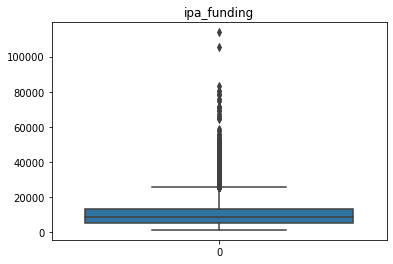

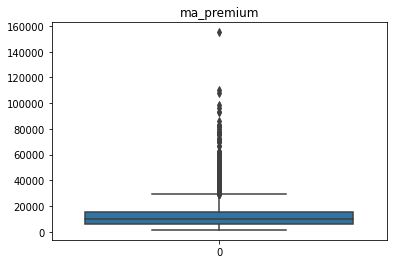

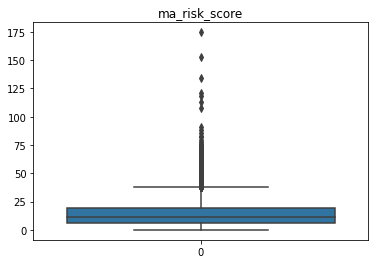

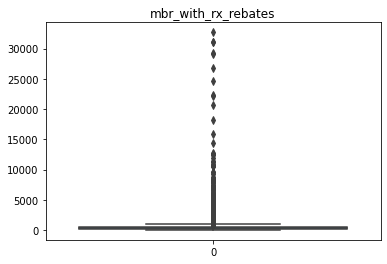

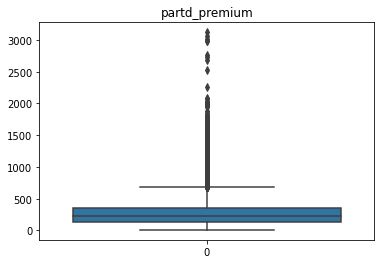

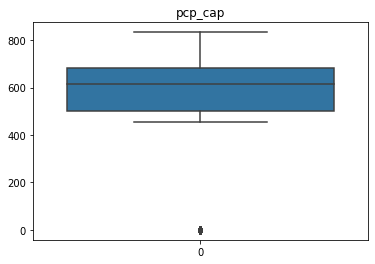

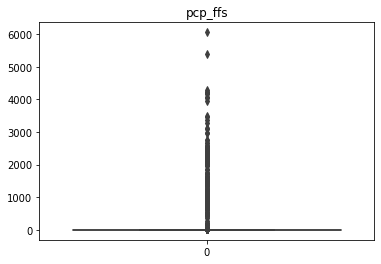

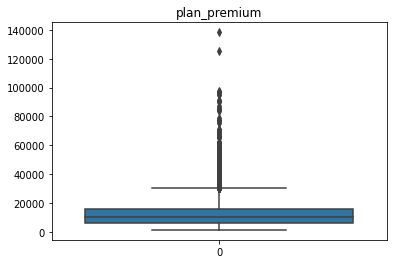

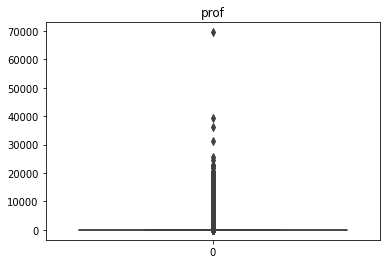

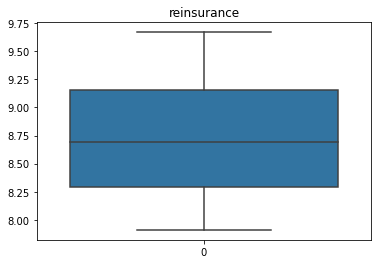

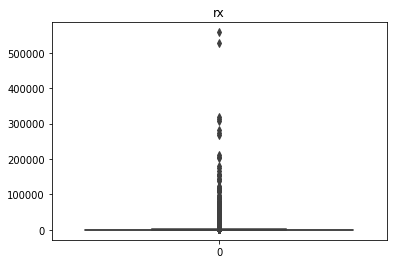

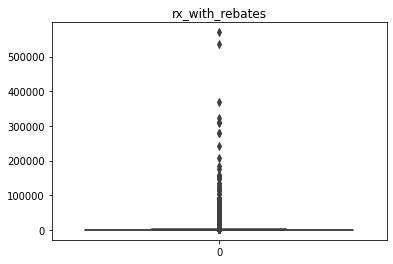

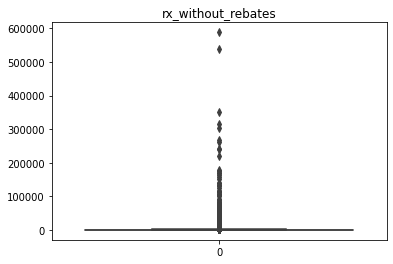

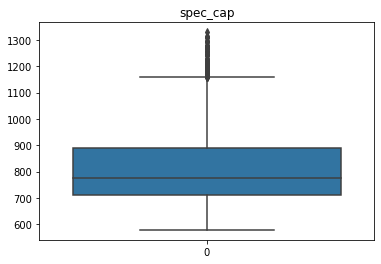

In [9]:
for i, financial_column in enumerate(financial_columns):
    plt.figure(figsize=(6, 4))
    plt.title(financial_column)
    sns.boxplot(data=sfrs[financial_column])

Almost all the columns have many outliers according to the box plots presented. Columns `reinsurance` and `pcp_cap` have no outliers, but very narrow range of values. This indicates that the columns have skewed distribution of values. Let's try to plot their distribution of values with a histogram and see if we can notice something interesting.

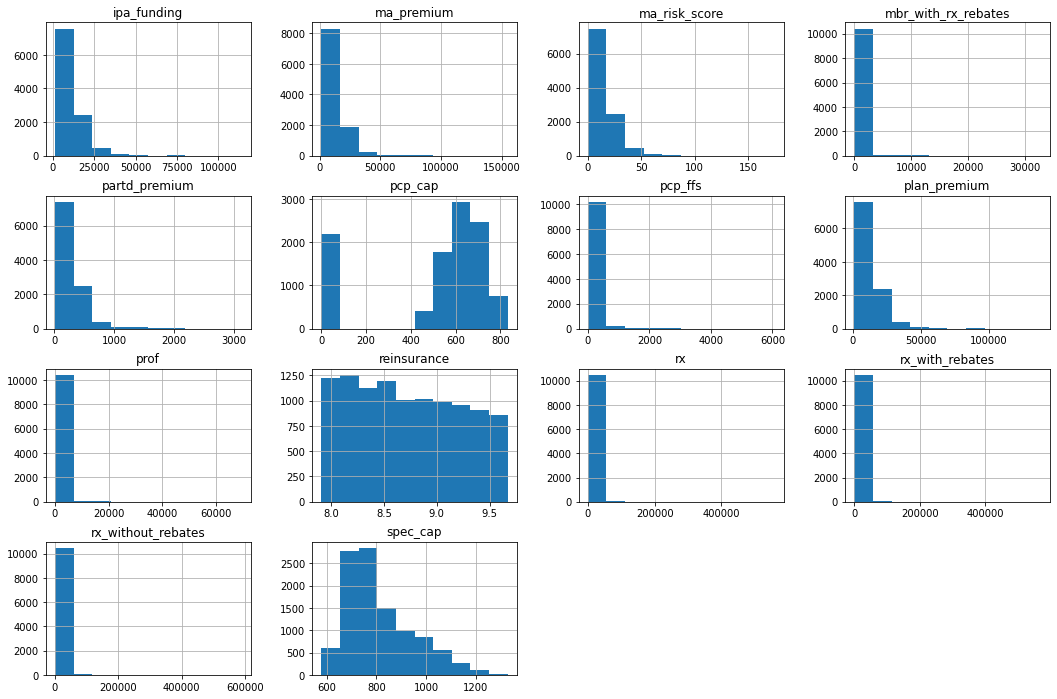

In [10]:
_ = sfrs[financial_columns].hist(figsize=(18, 12))

As expected, we can see that the columns which had a lot of outliers have the most skewed distribution of values, e.g., `rx`, `rx_with_rebates`, `prof`, etc. However, looking at these plots we can't conclude row-wise outliers; they only give us some sense about the range of values of each column and what value could potentially be treated as an outlier.

We will try one last approach towards the uni-variate outlier detection part of this assignment. We will standardize the value of each column, i.e., calculate its z-score. This is a statistical concept, where we assume that the columns have normal (Gaussian) distribution with a certain mean and standard deviation. The mean and standard deviation is different for each column, and we want to "standardize" them to a common value. This is done by transforming each value `x` with the formula:

```z = (x - mean) / std```

That way, all columns' means and standard deviations become 0 and 1, respectively. In Python this is implemented with the `scipy.stats.zscore` method. What the transformed value `z` represents, effectively, is how many standard deviation the value is away from its mean. If the value `z = 0` than that original value was the mean of its column. If `z = 1`, then the original value was `mean + 1 standard deviation`.

We know from statistics that the Gaussian distribution is symmetrical, and bell-shaped (if you need a refresher on this part, you can visit the [Wikipedia](https://en.wikipedia.org/wiki/Normal_distribution) article on it for quick info). The Gaussian distribution has the 3-sigma rule, or [68-95-99.7](https://en.wikipedia.org/wiki/68%E2%80%9395%E2%80%9399.7_rule), as it is on Wikipedia. This rule states that 68% of values are within one sigma, or one standard deviation, from the mean; 95% of values are within 2 std. devs. and 99.7% within 3 standard deviations.

We'll try to threshold the values `> 3` so that they are considered outliers. After all, they are supposed to be less than 0.3% in numbers, and more than three standard deviation away from the mean. Though, we expect way more than 0.3% of values, because the columns are far away from being normally distributed.

In [11]:
from scipy import stats
import numpy as np

# calculates the z-score for each value, column-wise
z = np.abs(stats.zscore(sfrs[financial_columns]))

# prints two arrays: one is row index, second is column index
# these values are essentially the outliers
print(np.where(z > 3))

(array([    4,    62,    62, ..., 10513, 10513, 10513]), array([8, 0, 1, ..., 1, 2, 7]))


In [12]:
sfrs_outliers = sfrs[financial_columns][(z > 3).any(axis=1)]
# this prints the rows which have at least one outlier in their value
sfrs.iloc[sfrs_outliers.index]

,member_unique_id,gender,dob,eligible_year,eligible_month,affiliation_type,pbp_group,plan_name,npi,line_of_business,...,pcp_ffs,plan_premium,prof,reinsurance,risk_score_partd,rx,rx_rebates,rx_with_rebates,rx_without_rebates,spec_cap
4,5,M,31/12/1953,2020,202006,Affiliate,NON-SNP,NaN,1,HMO,...,0.0,19976.13,8875.80,8.90,0.0,522.48,0.0,517.56,606.01,867.55
62,63,M,29/06/1944,2020,202006,Affiliate,D-SNP,NaN,1,HMO,...,0.0,52110.53,0.00,9.48,0.0,27513.95,0.0,30963.89,32025.88,957.09
107,108,M,18/05/1956,2020,202006,Affiliate,D-SNP,MEDICARE - CARENEEDS,1,HMO,...,0.0,36986.52,0.00,8.82,0.0,34279.67,0.0,35680.20,35819.58,818.94
122,123,M,30/06/1960,2020,202006,Affiliate,NON-SNP,NaN,1,HMO,...,0.0,26505.44,15684.94,9.19,0.0,370.58,0.0,443.31,381.42,941.42
130,131,F,07/03/1968,2020,202006,Affiliate,D-SNP,MEDICARE - CARENEEDS,2,HMO,...,0.0,15987.45,0.00,9.62,0.0,180462.51,0.0,155800.97,170609.15,794.62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10464,10465,F,15/11/1952,2020,202006,SaludVIP,D-SNP,MEDICARE - CARENEEDS,93,HMO,...,0.0,47530.73,0.00,8.58,0.0,16817.65,0.0,16056.29,15375.67,965.78
10467,10468,M,27/11/1962,2020,202006,SaludVIP,D-SNP,MEDICARE - CARENEEDS,93,HMO,...,0.0,68885.56,1464.21,9.34,0.0,0.00,0.0,0.00,0.00,849.53
10480,10481,M,28/06/1941,2020,202006,SaludVIP,D-SNP,NaN,93,HMO,...,0.0,42951.59,383.18,8.61,0.0,519.83,0.0,558.89,547.31,988.67
10504,10505,M,18/04/1945,2020,202006,SaludVIP,D-SNP,NaN,93,HMO,...,0.0,27758.45,1074.61,9.50,0.0,151.94,0.0,140.86,137.64,944.89


Moreover, we can print the rows which have more than one outlier. Since we have 14 columns, we will illustrate the example where the rows have more than 7 (half) values as outliers.

In [13]:
# take the row-index array
outliers_row_indices = np.where(z > 3)[0]

# count unique values
unique_values, counts = np.unique(outliers_row_indices, return_counts=True)

# transpose for easier manipulation
outlier_counts = np.array((unique_values, counts)).T

# try changing the threshold (number of columns that are considered outliers), and see the results
threshold = 7
outliers = [x for x in outlier_counts if x[1] > threshold]

# transform the array into the index
indices = [i[0] for i in outliers]

# print the outlier rows
sfrs.iloc[indices]

,member_unique_id,gender,dob,eligible_year,eligible_month,affiliation_type,pbp_group,plan_name,npi,line_of_business,...,pcp_ffs,plan_premium,prof,reinsurance,risk_score_partd,rx,rx_rebates,rx_with_rebates,rx_without_rebates,spec_cap
780,781,F,22/04/1965,2020,202006,Affiliate,NON-SNP,NaN,6,HMO,...,0.00,53792.64,4355.27,8.12,0.0,210082.16,0.0,207571.22,221233.01,718.21
1558,1559,M,09/04/1954,2020,202006,Affiliate,D-SNP,MEDICARE - CARENEEDS,12,HMO,...,2569.72,52416.81,14883.56,9.24,0.0,53395.04,0.0,50224.55,50035.92,904.75
2930,2931,F,06/07/1946,2020,202006,Affiliate,NON-SNP,MEDICARE - CAREFREE,23,HMO,...,0.00,45385.61,19028.78,8.62,0.0,144987.53,0.0,149322.70,134973.37,746.08
6497,6498,M,10/05/1961,2020,202006,VIPcare,NON-SNP,NaN,57,HMO,...,0.00,54523.31,0.00,9.26,0.0,557883.96,0.0,570037.03,588346.57,803.13
8494,8495,M,23/03/1960,2020,202006,Affiliate,D-SNP,MEDICARE - CARENEEDS,72,HMO,...,0.00,46395.36,8033.50,8.22,0.0,54213.57,0.0,59583.51,51639.04,1137.09


These are the members which have outlier values in more than half of their financial columns.

## Multi-variate outlier detection <a class="anchor" id="multi-variate-outlier-detection"></a>

In this section we will apply machine learning techniques to detect outliers. We will train some models that take **all** financial columns as input and output some kind of classification or categorization of whether the input is an outlier or not.

The [`sklearn`](https://scikit-learn.org/stable/index.html) library has implemented some of the most widely known and used machine learning algorithms for outlier detection: [isolation forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html) and [local outlier factor](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html).

The sklearn library has become the standard library for doing classical machine learning. It has started off as an internship project at Google, but since it was open-sourced its popularity grew and now, its repository on GitHub has over 50k stars and 24K forks! We recommend, when faced with a classical machine learning problem (not deep learning) to always check out sklearn first, you will usually find that a method that you need is already implemented.

In [14]:
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

In this assignment, we will apply the algorithms with their default parameters. However, we encourage you to try out different variations, and see what results you will get.

For the isolation forest algorithm, you might observe different results if you manipulate: `max_features`, `max_samples`, `n_estimators`, and maybe the `boostrap` flag. For the local outlier factor algorithm, we recommend playing around with the: `n_neighbors`, `algorithm`, `leaf_size`, and `metric` properties.

In [15]:
# instantiate object, and pass any custom parameters to the constructor
isolation_forest = IsolationForest()

# fit the model to the data
isolation_forest = isolation_forest.fit(sfrs[financial_columns])

# perform prediction, which returns -1 for an outlier, and 1 for an inlier
inference = isolation_forest.predict(sfrs[financial_columns])

# parse indices where the algorithm predicted an outlier
indices_if = np.where(inference == -1)[0]  # np.where() returns a tuple of one element

print("There are", len(indices_if), "members marked as outliers")

sfrs.iloc[indices_if]

There are 1138 members marked as outliers


,member_unique_id,gender,dob,eligible_year,eligible_month,affiliation_type,pbp_group,plan_name,npi,line_of_business,...,pcp_ffs,plan_premium,prof,reinsurance,risk_score_partd,rx,rx_rebates,rx_with_rebates,rx_without_rebates,spec_cap
1,2,M,02/01/1948,2020,202006,Affiliate,NON-SNP,NaN,1,HMO,...,0.0,6204.84,0.00,8.13,0.0,11289.69,0.0,10688.46,10859.82,906.77
4,5,M,31/12/1953,2020,202006,Affiliate,NON-SNP,NaN,1,HMO,...,0.0,19976.13,8875.80,8.90,0.0,522.48,0.0,517.56,606.01,867.55
26,27,M,10/05/1955,2020,202006,Affiliate,NON-SNP,NaN,1,HMO,...,0.0,5229.48,0.00,8.79,0.0,12753.16,0.0,13866.12,13189.06,957.09
38,39,M,31/03/1938,2020,202006,Affiliate,D-SNP,MEDICARE - CARENEEDS,1,HMO,...,0.0,29082.72,3197.58,8.42,0.0,4727.12,0.0,4746.47,4215.73,826.00
54,55,F,29/01/1952,2020,202006,Affiliate,NON-SNP,MEDICARE - CAREFREE,1,HMO,...,0.0,8227.35,0.00,9.26,0.0,13578.86,0.0,14515.80,15042.28,943.48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10473,10474,F,25/01/1931,2020,202006,SaludVIP,NON-SNP,NaN,93,HMO,...,0.0,24552.03,0.00,8.56,0.0,13142.53,0.0,14746.97,15316.04,872.14
10477,10478,M,16/05/1954,2020,202006,SaludVIP,D-SNP,MEDICARE - CARENEEDS,93,HMO,...,0.0,23861.66,957.03,8.19,0.0,11022.89,0.0,13295.90,12065.29,960.72
10480,10481,M,28/06/1941,2020,202006,SaludVIP,D-SNP,NaN,93,HMO,...,0.0,42951.59,383.18,8.61,0.0,519.83,0.0,558.89,547.31,988.67
10504,10505,M,18/04/1945,2020,202006,SaludVIP,D-SNP,NaN,93,HMO,...,0.0,27758.45,1074.61,9.50,0.0,151.94,0.0,140.86,137.64,944.89


We repeat the same procedure with the local outlier factor algorithm.

In [16]:
# instantiate object, and pass any custom parameters to the constructor
local_outlier_factor = LocalOutlierFactor()

# fit & predict to the data
inference = local_outlier_factor.fit_predict(sfrs[financial_columns])

# parse outlier indices
indices_lof = np.where(inference == -1)[0]

print("There are", len(indices_lof), "members marked as outliers")

sfrs.iloc[indices_lof]

There are 258 members marked as outliers


,member_unique_id,gender,dob,eligible_year,eligible_month,affiliation_type,pbp_group,plan_name,npi,line_of_business,...,pcp_ffs,plan_premium,prof,reinsurance,risk_score_partd,rx,rx_rebates,rx_with_rebates,rx_without_rebates,spec_cap
21,22,M,28/07/1953,2020,202006,Affiliate,NON-SNP,MEDICARE - CAREFREE,1,HMO,...,0.0,4889.90,0.00,9.25,0.0,0.00,0.0,0.00,0.00,838.04
69,70,M,19/10/1959,2020,202006,Affiliate,NON-SNP,MEDICARE - CAREFREE,1,HMO,...,0.0,6355.39,808.15,7.94,0.0,0.00,0.0,0.00,0.00,863.20
71,72,F,30/04/1951,2020,202006,Affiliate,NON-SNP,MEDICARE - CAREFREE,1,HMO,...,0.0,5049.74,0.00,8.00,0.0,0.00,0.0,0.00,0.00,788.97
153,154,F,28/08/1939,2020,202006,Affiliate,NON-SNP,MEDICARE - CAREFREE,2,HMO,...,0.0,5524.63,1215.20,8.06,0.0,536.10,0.0,631.26,587.23,797.12
280,281,M,16/10/1950,2020,202006,Affiliate,D-SNP,MEDICARE - CARENEEDS,5,HMO,...,0.0,7613.64,0.00,8.55,0.0,0.00,0.0,0.00,0.00,849.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10393,10394,F,11/09/1970,2020,202006,VIPcare,NON-SNP,NaN,91,HMO,...,0.0,27777.57,0.00,8.25,0.0,282935.14,0.0,307263.96,267754.53,983.67
10416,10417,F,01/10/1952,2020,202006,Affiliate,NON-SNP,NaN,92,HMO,...,0.0,26991.41,20216.10,8.26,0.0,39042.92,0.0,40740.43,34167.00,674.73
10446,10447,M,05/09/1939,2020,202006,SaludVIP,NON-SNP,NaN,93,HMO,...,0.0,31192.02,8272.33,7.97,0.0,20628.43,0.0,17266.76,18408.79,891.63
10461,10462,M,04/08/1980,2020,202006,SaludVIP,D-SNP,MEDICARE - CARENEEDS,93,HMO,...,0.0,11707.19,0.00,9.03,0.0,0.00,0.0,0.00,0.00,885.61


There's quite some discrepancy between the predictions of both algorithms; isolation forest predicts 925 members as outliers, while local outlier factor predicts only 258 as such. To become more confident in our predictions for an outlier, we can mark as such only those individuals that have been predicted as outliers by both algorithms.

We can achieve that quite easily, by taking the intersection of indices from both algorithms. This is one-liner in Python, but does require some type conversion, so study carefully the first line in the next cell.

In [17]:
common_indices = list(set(indices_if).intersection(set(indices_lof)))
sfrs.iloc[common_indices]

,member_unique_id,gender,dob,eligible_year,eligible_month,affiliation_type,pbp_group,plan_name,npi,line_of_business,...,pcp_ffs,plan_premium,prof,reinsurance,risk_score_partd,rx,rx_rebates,rx_with_rebates,rx_without_rebates,spec_cap
2561,2562,M,15/08/1947,2020,202006,Affiliate,NON-SNP,MEDICARE - CAREFREE,20,HMO,...,0.00,21796.83,39523.72,8.76,0.0,2095.67,0.0,1913.95,2188.25,962.69
7170,7171,M,12/06/1932,2020,202006,Affiliate,D-SNP,MEDICARE - CARENEEDS,61,HMO,...,0.00,26351.77,12994.91,8.09,0.0,0.00,0.0,0.00,0.00,1038.88
6662,6663,F,15/09/1951,2020,202006,Affiliate,NON-SNP,NaN,58,HMO,...,4161.69,7034.44,4351.99,8.48,0.0,597.39,0.0,551.25,551.25,771.61
9734,9735,M,12/12/1941,2020,202006,VIPcare,NON-SNP,NaN,85,HMO,...,0.00,7977.05,4401.54,9.14,0.0,95.73,0.0,92.94,105.10,894.95
3602,3603,F,07/11/1944,2020,202006,Affiliate,NON-SNP,NaN,26,HMO,...,4286.85,12275.82,4477.37,9.10,0.0,5249.51,0.0,4683.94,5220.85,712.35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9709,9710,M,21/05/1940,2020,202006,VIPcare,D-SNP,MEDICARE - CARENEEDS,85,HMO,...,0.00,34069.08,9367.75,9.51,0.0,4344.18,0.0,4321.93,3859.29,1036.52
495,496,F,18/11/1946,2020,202006,Affiliate,NON-SNP,NaN,5,HMO,...,0.00,35222.58,24422.50,7.96,0.0,121.34,0.0,134.57,115.22,821.88
5104,5105,F,12/06/1950,2020,202006,Affiliate,NON-SNP,MEDICARE - CAREFREE,38,HMO,...,0.00,3927.14,1041.67,9.46,0.0,6918.37,0.0,7600.16,7290.10,721.85
3574,3575,M,08/04/1955,2020,202006,Affiliate,D-SNP,NaN,26,HMO,...,747.07,10781.36,3468.13,8.43,0.0,4480.10,0.0,4559.36,5265.32,796.47


There are 111 members that are identified as outliers by both algorithms. At this point, we have conducted an extensive outlier detection analysis. We have performed uni- and multi-variate analyses, both descriptive and predictive. As a final presentation, we can plot the distribution of the values in the financial columns only for the detected outliers and try to compare with the previous one over the entire data set. Try if you can notice any differences and explain as to why these members were identified as outliers. Note that you can always go back to the algorithms and modify their hyperparameters - the end results will change!

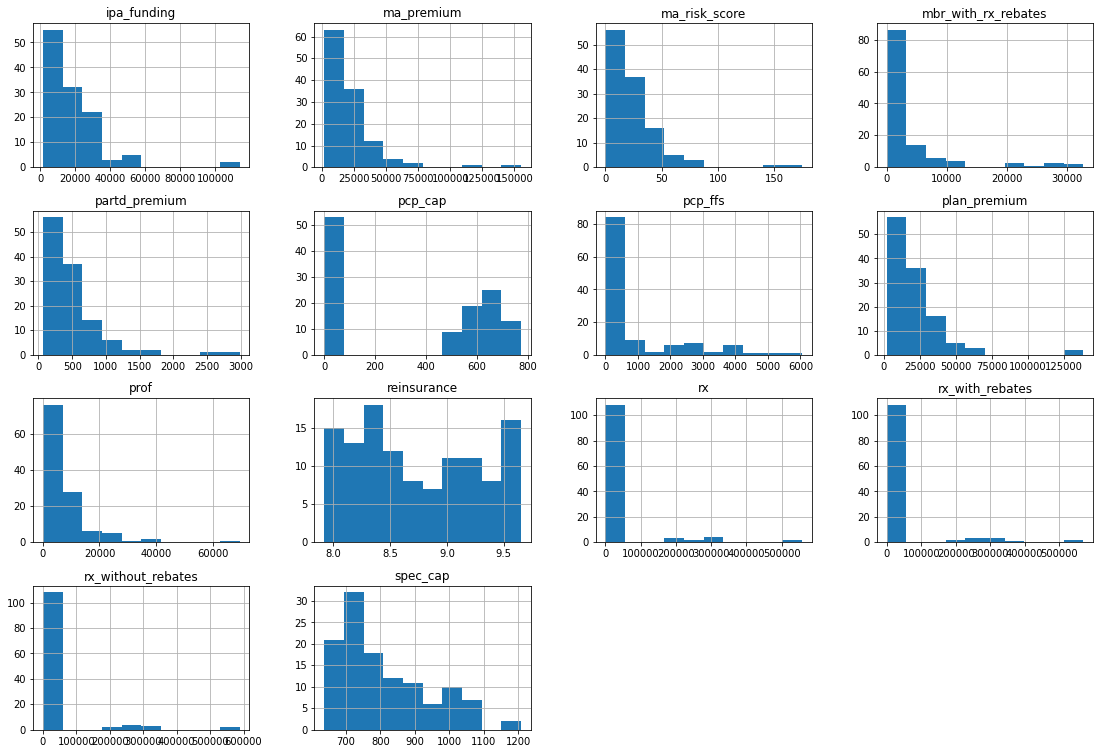

In [18]:
_ = sfrs.iloc[common_indices][financial_columns].hist(figsize=(19, 13))